<a href="https://colab.research.google.com/github/minhluu99/minhluu99/blob/main/cGANv2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mô hình C-GAN sử dụng nền tảng tensorflow, source code được phát triển từ bài hướng dẫn DCGAN của tensorflow

# **Kết nối Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Setup**

## **Lib**

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import PIL
from PIL import Image
import time
import os
import json

from IPython import display

# **Prepare CoCo**

In [ ]:
# Kiểm tra thư mục làm việc hiện tại
print("Vị trí thư mục làm việc hiện tại là       : " + os.getcwd())
Y_N = input("nhấn 1 là có                        : " )
if Y_N ==  "1":
  os.chdir('/content')
  print('thư mục làm việc hiện tại là            : ' + os.getcwd())
else:
  print(' đã từ chối chuyển đến \'content\' ')

Vị trí thư mục làm việc hiện tại là       : /content
nhấn 1 là có                        : n
 đã từ chối chuyển đến 'content' 


In [ ]:
# Download instance annotation files
annotation_folder = '/annotations/'
if not os.path.exists(os.path.abspath('.') + annotation_folder):
  annotation_zip = tf.keras.utils.get_file('captions.zip',
                                           cache_subdir=os.path.abspath('.'),
                                           origin='http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
                                           extract=True)
  os.remove(annotation_zip)
caption_file = os.path.abspath('.') + '/annotations/captions_train2014.json'
instance_file = os.path.abspath('.') + '/annotations/instances_train2014.json'

252887040/252872794 [==============================] - 6s 0us/step


## ***enter image_folder address***

In [ ]:
image_folder = "/content/drive/MyDrive/GAN_image"
while os.path.exists(image_folder) == 0:
  print(" không có thư mục này hoặc thư mục đã bị xóa !!!")
  print(" Hãy kiểm tra lại kết nối tới Drive             ")
  image_folder = input("nhập lại địa chỉ mới: ")
  if image_folder == 'n':
    print("\nBạn đã từ chối nhập địa chỉ")
    break
if os.path.exists(image_folder) == 1:
  print('\nĐã cập nhập thư mục ảnh : ' + image_folder)


Đã cập nhập thư mục ảnh : /content/drive/MyDrive/GAN_image


In [ ]:
imgId = []
for i in os.listdir(image_folder):
  if i == '.DS_Store':
    continue
  i = i.replace('COCO_train2014_','')
  i = i.replace('.jpg','')
  imgId.append(int(i))
print('số hình ảnh kiếm được: {}'.format(len(imgId)))
print(imgId[0])

số hình ảnh kiếm được: 2737
260393


## **get_cat_or_cap**

In [ ]:
with open(instance_file, 'r') as f:
    cat_json = json.load(f)

In [ ]:
CatNa = []
CatId  = []
for val in cat_json['categories']:
  if val['supercategory'] in ['furniture']:
    CatNa.append(val['name'])
    CatId.append(val['id'])
print(CatId)
print(CatNa)

[62, 63, 64, 65, 67, 70]
['chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet']


In [ ]:
CatNa =['chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet']
CatId  = [62, 63, 64, 65, 67, 70]

In [ ]:
cat_ID = []
img_ID = []
for val in cat_json['annotations']:
  if val['category_id'] in CatId:
    if val['image_id'] in imgId:
      img_ID.append(val['image_id'])
      for i in range(len(CatId)):
        if val['category_id'] == CatId[i]:
          cat_ID.append(i)
print("Số lượng ảnh và nhãn            : " + str(len(img_ID)) + " - " +str(len(cat_ID)))
print("Đã chuyển số ID của category về : " + str(max(cat_ID)) + " - " +str(min(cat_ID)))

Số lượng ảnh và nhãn            : 8307 - 8307
Đã chuyển số ID của category về : 5 - 0


## **tensorflow_dataset**

In [ ]:
def map_ID_to_array(img_id,cap_or_cat):
  # Map ID to Addr
  image_path = os.path.join(image_folder , 'COCO_train2014_' + '%012d.jpg' % img_ID[0])
  # Map Addr to Img
  img = Image.open(image_path)
  img = img.resize((64,64))
  img_array = np.array(img).astype('float32')
  img_array = img_array/255 -1
  return img_array,cap_or_cat

In [ ]:
BUFFER_SIZE = len(img_ID)
BATCH_SIZE = 256
dataset = tf.data.Dataset.from_tensor_slices((img_ID, cat_ID))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_ID_to_array, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# **Build_model**

## **Generator**

In [ ]:
# yều cầu là tạo ra hình ảnh 64x64x3
def make_generator_model(n_classes = 6):
    in_label = layers.Input(shape=(1,))
    li = layers.Embedding(n_classes, 50)(in_label)
    n_nodes = 8 * 8
    li = layers.Dense(n_nodes, use_bias= False)(li)
    li = layers.Reshape((8, 8, 1))(li)


    input_latent = layers.Input(shape=(100, ))
    g_lay = layers.Dense(256 * 8 * 8, use_bias=False)
    g_lay = g_lay(input_latent)
    g_lay = layers.BatchNormalization()(g_lay)
    g_lay = layers.LeakyReLU()(g_lay)

    g_lay = layers.Reshape((8, 8, 256))(g_lay)
    assert tuple(g_lay.shape) == (None, 8, 8, 256)
    merge = layers.Concatenate()([g_lay, li])
    # Note: None is the batch size
    #lệnh assert dùng để kiểm tra output, nếu output không như mong muốn
    #nó sẽ báo lỗi tại đây

    g_lay = layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False)(merge)
    assert tuple(g_lay.shape) == (None, 8, 8, 128)
    g_lay = layers.BatchNormalization()(g_lay)
    g_lay = layers.LeakyReLU()(g_lay)
    

    g_lay = layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False)(g_lay)
    assert tuple(g_lay.shape) == (None, 16, 16, 64)
    g_lay = layers.BatchNormalization()(g_lay)
    g_lay = layers.LeakyReLU()(g_lay)

    g_lay = layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False)(g_lay)
    assert tuple(g_lay.shape) == (None, 32, 32, 32)
    g_lay = layers.BatchNormalization()(g_lay)
    g_lay = layers.LeakyReLU()(g_lay)

    out_lay = layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation= 'tanh')(g_lay)
    assert tuple(out_lay.shape) == (None, 64, 64, 3)

    return tf.keras.Model([input_latent,in_label],out_lay)

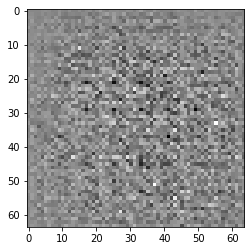

In [ ]:
generator = make_generator_model()
noise = tf.random.normal([1, 100])
generated_image = generator([noise,np.array([1])], training=False)
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

## **Discriminator**

In [ ]:
def make_discriminator_model(n_classes=6):
    in_label = layers.Input(shape=(1,))
    li = layers.Embedding(n_classes, 50)(in_label)
    n_nodes = 64 * 64
    li = layers.Dense(n_nodes, use_bias= False)(li)
    li = layers.Reshape((64, 64, 1))(li)

    input = layers.Input(shape = (64,64,3))
    d_lay = layers.Concatenate()([input,li])
    d_lay = layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same')(d_lay)
    assert tuple(d_lay.shape) == (None,32,32,64)
    d_lay = layers.LeakyReLU()(d_lay)
    d_lay = layers.Dropout(0.3)(d_lay)

    d_lay = layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same')(d_lay)
    assert tuple(d_lay.shape) == (None,16,16,128)
    d_lay = layers.LeakyReLU()(d_lay)
    d_lay = layers.Dropout(0.3)(d_lay)

    d_lay = layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same')(d_lay)
    assert tuple(d_lay.shape) == (None,8,8,256)
    d_lay = layers.LeakyReLU()(d_lay)
    d_lay = layers.Dropout(0.3)(d_lay)

    d_lay = layers.Flatten()(d_lay)
    out_lay = layers.Dense(1)(d_lay)

    return tf.keras.Model([input,in_label],out_lay)

In [ ]:
discriminator = make_discriminator_model()
decision = discriminator([generated_image,np.array([1])])
print (decision)

tf.Tensor([[-0.00010186]], shape=(1, 1), dtype=float32)


## **Define the loss and optimizers**

In [ ]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
# Discriminator_loss
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [ ]:
# Generator_loss
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
# Optimizer
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# **Save_checkpoints**

In [ ]:
checkpoint_dir = '../content/drive/MyDrive/series_GAN/c_gan'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)



# **The training loop**

In [ ]:
EPOCHS = 300
noise_dim = 100
num_examples_to_generate = 3*6

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed_image = tf.random.normal([num_examples_to_generate, noise_dim])
seed_label = np.asarray([x for _ in range(3) for x in range(6)])
print('shape of seed_image: {}'.format(seed_image.shape))
print('shape of seed_label: {}'.format(seed_label.shape))
print('content of seed_label: ')
print(seed_label)

shape of seed_image: (18, 100)
shape of seed_label: (18,)
content of seed_label: 
[0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5]


In [ ]:
for images,labels in dataset:
  images.shape
  labels.shape

In [ ]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images,labels):
    noise = tf.random.normal([labels.shape[0], noise_dim])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator([noise,labels], training=True)
      
      real_output = discriminator([images,labels], training=True)

      fake_output = discriminator([generated_images,labels], training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return [gen_loss,disc_loss]

In [ ]:
def generate_and_save_images(model, epoch, test_input,label,restore):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model([test_input,label], training=False)

  fig = plt.figure(figsize=(12, 12))

  for i in range(predictions.shape[0]):
      plt.subplot(3, 6, i+1,)
      plt.title(CatNa[i%6])
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5)
      plt.axis('off')
  plt.savefig('../content/drive/MyDrive/series_GAN/img_save_loss/image_at_epoch_{:02d}_{:04d}.png'.format(restore,epoch))
  plt.show()

In [ ]:
def save_loss(D_loss,G_loss,stt,restore):
  if restore ==0:
    mode = 'w+'
  else:
    mode = 'a+'
  with open('../content/drive/MyDrive/series_GAN/img_save_loss/loss.txt','w+') as f:
      for i in D_loss:
        f.write('D{}--'.format(i))
      for i in G_loss:
        f.write('G{}--'.format(i))
      for i in stt:
        f.write('s{}--'.format(i))

In [ ]:
def train(dataset, epochs,restore = 0):
  # check checkpoint restore
  if restore == 1 :
    if tf.train.latest_checkpoint(checkpoint_dir) != None:
      checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
      print("Restored from {}".format(tf.train.latest_checkpoint(checkpoint_dir)))
      restore = int(tf.train.latest_checkpoint(checkpoint_dir)[-1])
      try:
        restore = int(tf.train.latest_checkpoint(checkpoint_dir)[-2:])
      finally:
        restore = int(tf.train.latest_checkpoint(checkpoint_dir)[-1])
    else:
      print('couldn''t find the last checkpoint')
      ans = input('press ''n'' if you don''t want to train from scratch: ')
      if ans == 'n':
        print('ok, you don''t want to train ')
        return
      else:
        print('train from scratch')
        restore = 0
  else:
    print('train from scratch')
  
  #train_model
  Discriminator_loss = []
  Generator_loss = []
  m_epoch = []
  for epoch in range(epochs):
    start = time.time()

    for image_batch,labels in dataset:
      gen_loss,disc_loss = train_step(image_batch,labels)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed_image,seed_label,restore)
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
    print ('D_loss : {} || G_loss: {}'.format(disc_loss,gen_loss))
    
    # Save the model every 20 epochs
    if (epoch + 1) % 20 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)
      Discriminator_loss.append(disc_loss)
      Generator_loss.append(gen_loss)
      m_epoch.append(epoch)
    
  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed_image,seed_label,restore)
  save_loss(Discriminator_loss,Generator_loss,m_epoch,restore)

# **Train_model**

In [ ]:
train(dataset, EPOCHS)

# **Restore_train_model**

In [ ]:
# train(dataset, EPOCHS,restore=1)

# **show_img_result**

In [ ]:
def generate_and_show_images(model, test_input,label):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model([test_input,label], training=False)

  fig = plt.figure(figsize=(12, 12))

  for i in range(predictions.shape[0]):
      plt.subplot(3, 6, i+1,)
      plt.title(CatNa[i%6])
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5)
      plt.axis('off')
  plt.show()

checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

seed_image = tf.random.normal([num_examples_to_generate, noise_dim])
seed_label = np.asarray([x for _ in range(3) for x in range(6)])
print('shape of seed_image: {}'.format(seed_image.shape))
print('shape of seed_label: {}'.format(seed_label.shape))
print('content of seed_label: ')
print(seed_label)
generate_and_show_images(generator,seed_image,seed_label)